In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])
a = pd.read_csv('a.csv.gz',index_col=0,parse_dates=[0])
b = pd.read_csv('b.csv.gz',index_col=0,parse_dates=[0])
s = pd.read_csv('s.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-29"

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

volume_estimate=pd.read_csv('volume_estimate.csv.gz',index_col=0,parse_dates=[0])
sigma_estimate=pd.read_csv('sigma_estimate.csv.gz',index_col=0,parse_dates=[0])

all_return_estimates={}
np.random.seed(0)
n_p1=returns.shape[1]
T=returns.shape[0]
for i,t in enumerate(returns.index[:-1]):
    all_return_estimates[(t,t)]=returns.loc[t]+0.1*np.random.randn(n_p1)
    all_return_estimates[(t,t)].USDOLLAR=returns.loc[t].ix[-1]
    tp1 = returns.index[i+1] 
    all_return_estimates[(t,tp1)]=returns.loc[tp1]+0.1*np.random.randn(n_p1)
    all_return_estimates[(t,tp1)].USDOLLAR=returns.loc[tp1].ix[-1]

alpha_model = cp.MPOAlphaSource(all_return_estimates)
optimization_tcost=cp.TcostModel(volume_estimate, sigma_estimate, a, b, cash_key='USDOLLAR')
optimization_hcost=cp.HcostModel(s, cash_key='USDOLLAR')

risk_data = pd.HDFStore('risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import cvxpy as cvx

gamma_tcost = 100.
gamma_risk = 100.

policies={}
gamma_risks=[ 20., 50,  200., 500., 2000.,5000.]#[ 20., 50, 100. , 200., 500., 1000,2000.,5000., 10000]
gamma_tcosts=[ 100., 140.,200.]
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(alpha_model=alpha_model, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)#,solver=cvx.SCS)

results.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=True))})

INFO:root:Backtest started, from 2012-01-03 00:00:00 to 2016-12-29 00:00:00
INFO:root:Getting trades at time 2012-01-03 00:00:00
INFO:root:Propagating portfolio at time 2012-01-03 00:00:00
INFO:root:Getting trades at time 2012-01-04 00:00:00
INFO:root:Propagating portfolio at time 2012-01-04 00:00:00
INFO:root:Getting trades at time 2012-01-05 00:00:00
INFO:root:Propagating portfolio at time 2012-01-05 00:00:00
INFO:root:Getting trades at time 2012-01-06 00:00:00
INFO:root:Propagating portfolio at time 2012-01-06 00:00:00
INFO:root:Getting trades at time 2012-01-09 00:00:00
INFO:root:Propagating portfolio at time 2012-01-09 00:00:00
INFO:root:Getting trades at time 2012-01-10 00:00:00
INFO:root:Propagating portfolio at time 2012-01-10 00:00:00
INFO:root:Getting trades at time 2012-01-11 00:00:00
INFO:root:Propagating portfolio at time 2012-01-11 00:00:00
INFO:root:Getting trades at time 2012-01-12 00:00:00
INFO:root:Propagating portfolio at time 2012-01-12 00:00:00
INFO:root:Getting tr

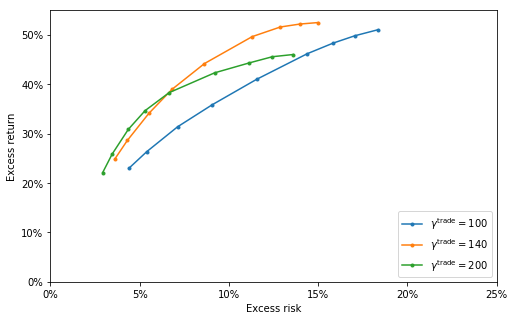

In [57]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], k[1]] = results[k]
    
result_df=result_df.loc[sorted(result_df.index)]

plt.figure(figsize=(8,5))

for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Excess risk')
plt.ylabel('Excess return')
plt.xlim([0,25])
plt.ylim([0,55])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'mpo_riskrewardfrontier.png')